## On the Job Search Insurance

### Carlos Lizama, Benjamín Villena

#### Brief summary of the model
* On-the-job search model. Each workers has an idiosyncratic process $x$ which determines the probability of being fired each period. The process has some persistance.
* If the worker switch jobs, the underlying variable $x$ starts from its steady state value.
* Wages are drawn from an exogneous distribution.
* Job finding probability $p(s)$ depends on effort $s$.
* There is no self-insurance, ie, agents can not save nor borrow.

#### Equations

The value on unemployment is determined by

$$(1-\beta) U = u(b) - \lambda s^* + \beta p(s) \int_{w^*}^{\bar{w}} (W(w, \bar{x}) - U) dF(w)$$

where $w^*$ is the reservation wage $W(w^*, \bar{x}) = U$ and $s^*$ is determined by
$$\lambda = \beta p'(s) \int_{w^*}^{\bar{w}} (W(w, \bar{x}) - U) dF(w)$$

The value of employement, state $(w,x)$ is

$$W(w,x) = u(w) - \lambda s^* + \beta \left\{ p(s) \left[ \int_{w^*(w,x)}^{\bar{w}} \left( W(w',x) - \int W(w,x') dG(x'|x) \right) dF(w') +\delta(x) \left( \int W(w,x') dG(x'|x) - U \right)  \right] + \delta(x) U + (1-\delta(x)) \int W(w,x') dG(x'|x) \right\}$$

where $w^*(w,x)$ is such that $W(w^*(w,x),x) = \int W(w,x') dG(x'|x)$ and $s^*(w,x)$ is determined by
$$\lambda = \beta p'(s) \left\{ \int_{w^(w,x)}^{\bar{w}} \left( W(w',x) - W(w,x') dG(x'|x) \right) dF(w') + \delta(x) \left( \int W(w,x') dG(x'|x) - U \right) \right\}$$

#### Functional forms
Need to set functional forms to $u(c), F(w), p(s), G(x'|x), \delta(x)$

* $u(c) = \frac{c^{1-\sigma}}{1-\sigma}$, with $\sigma = 2$
* $F(w)$ is truncated Pareto
* $p(s)$ is exponential.
* $G(x'|x)$: x follows and AR(1), discretized.
* $\delta(x)$ is normal. 

Of course, all of these parametrization can be changed. 

The choice of utility function is standard in the literature.

I chose truncated Pareto since wages the data follow approximately a Pareto distribution. Another possibility is to change it by a log-normal. The code is made in such a way that this kind of changes are easy to make.

The exponential function for the job finding probability is to consider decreasing returns to effort and effort to be defined from 0 to infinity.

AR(1) for x just to make it a Markov process and easy to discretize.

#### Parameters
Need to set values for discount factor $\beta$, persistence of idiosyncratic process $\rho$, effort cost $\lambda$, unemployment benefits $b$


In [1]:
## Import Packages
using Distributions
using Roots
using PyPlot

I define a couple of functions that I will use throughout the code.

In [2]:
"""
Rowenhorst method for approximating AR(1) processes, z_{t+1} = (1-ρ)μ + ρ z_t + ɛ, where ɛ ∼ N(0,σ²)

Inputs 
μ: unconditional mean of the process
ρ: persistence of the process
σ: standard deviation of innovations
N: number of gridpoints 

Output
z: gridpoints, points where the discrete version of the AR(1) takes values, dim = N
P: transition matrix between states, dim NxN

"""
function Rouwenhorst(μ, ρ, σ, N)
    
    # grid points
    σz = sqrt(σ^2/(1-ρ^2)) 
    ψ = σz*sqrt(N-1)
    z = μ + collect(linspace(-ψ,ψ,N))
    
    # transition matrix
    p = (1+ρ)/2
    q = (1+ρ)/2
    
    P = [p 1-p; 1-q q]
    
    for n=3:N
        v0 = zeros(n-1,1)
        P = p*[P v0; v0' 0] + (1-p)*[v0 P; 0 v0'] +(1-q)*[v0' 0; P v0] + q*[0 v0'; v0 P];
        P[2:end-1,:] = P[2:end-1,:]/2;
    end
     
    return z,P
    
end

Rouwenhorst (generic function with 1 method)

In [3]:
"""
Trapezoidal method  for computing integrals. This method also works for non-uniform grids.
∫ₐᵇ f(x) dx = 1/2 ∑ (x_{k+1}-x_{k}) (f(x_{k+1}) + f(x_k))
"""
function Trapezoidal(x,f)
    
    I = (x[2:end]-x[1:end-1])'*(f[2:end]+f[1:end-1])/2
    
    return I[1]
end


Trapezoidal (generic function with 1 method)

In [4]:
## Paramtrization/Calibration

# Parameter
β = 0.95    # discount factor
ρ = 0.75    # persistence of AR(1) process
λ = 1       # marginal cost of effort
b = 20.      # unemployment benefits
σ = 2.       # risk aversion
σₑ = .01      # std of innovations in AR(1) process
Nx = 11     # number of points in the discretized process of x. Odd number so the middle point is on the grid.
n0 = Int(ceil(Nx/2))   # index of middle x.
Nw = 20     # number of gridpoints in grid for w.

u(x) = x.^(1-σ)/(1-σ)  # utility function
w₋ = 10.                # lower limit of wage distribution
w⁻ = 100.              # upper limit of wage distribution
w = w₋ + (w⁻-w₋)*linspace(0,1,Nw)    # w grid. the .^2 is to make a non-uniform grid to capture 
                                        # more curvature at the beginnning of the grid 

Ub = u(b)
Uw = u(repmat(w,1,Nx))   # utility of consuming w in each state (w,x).

# define F
α = 1.01                 # parameter of Pareto distribution
F₀ = Pareto(α, w₋)
F₁ = Truncated(F₀, w₋, w⁻)   # truncate Pareto.
F = pdf(F₁, w)
sumF = Trapezoidal(w, F)
F = F/sumF             # discretization of wage distribution, measure over each gridpoint of w.

# define p, p(s) is job finding rate depending on effort. For this case, p is an exponential distribution.
θₑ = 0.001                # parameter of exponential distribution
pdist = Exponential(θₑ)
p(s) = pdf(pdist, s) 
P(s) = cdf(pdist, s)

# Discretize AR(1) process.
δ = Normal()                   # define δ
q = quantile(δ,.02)
x, Px = Rouwenhorst(q, ρ, σₑ, Nx)   # x underlying process of dismissal, Px transition matrix
δₓ = cdf(δ,x)                  # δ(x) probability of being dismissed.
δX = repmat(δₓ',Nw,1)          # δ(x) as a matrix, I will use it, it is usefull to vectorize calculations.

## Initial guess
U = Ub
W = Uw
S = 0.01*ones(Nw,Nx)
s0 = 0.01
Sp = zeros(Nw,Nx)
Ex = zeros(Nw,Nx)   # Expected value condition on x, E[W(w,x')|x]
I1 = zeros(Nw,Nx)   # integral in optimal effort for unemployed  
I = zeros(Nw,Nx)    # integral in optimal effort for employed

ii=0 # used for debugging
jj=0

0

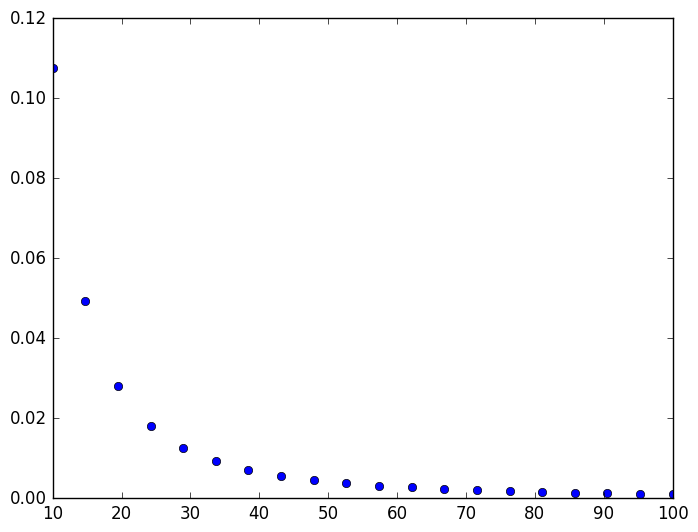

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31d42e4e0>

In [5]:
# Show distribution of wages
plot(w,F,"o")


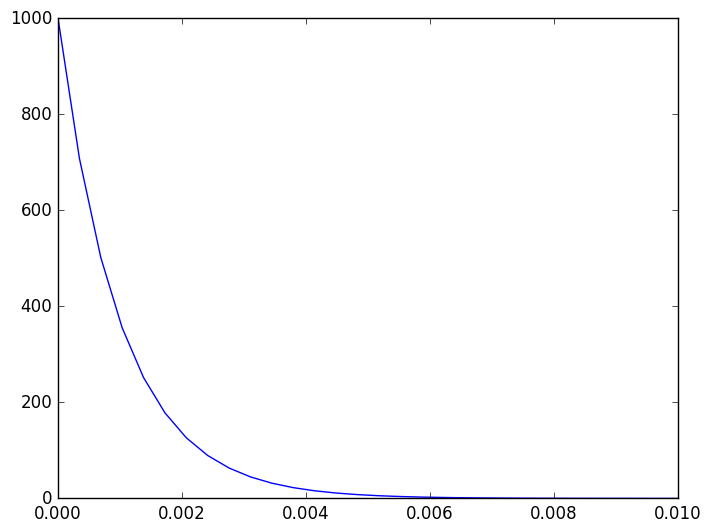

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31d6578d0>

In [9]:
# job finding probability given effort s
plot(linspace(0,.01,30), p(linspace(0,.01,30)))

In [12]:
## Algorithm: Value function Iteration

ɛ = 1e-6
T = 10   
iter=0

for t=1:T

    iter+=1 
    
    # optimal effort for unemployed worker
    I0 = Trapezoidal(w, (max(W[:,n0]-U,0).*F))
    f(s) = λ/(β*I0)- p(s)
    s0p = fzero(f, [0, 50])

    # optimal effort for employed worker
    for i=1:Nw
        ii=ii+1
        for j=1:Nx
            jj=jj+1
            Ex[i,j] = (W[i,:]*Px[j,:]')[1]
            I1[i,j] = Trapezoidal(w, (max(W[:,j]-Ex[i,j],0).*F))
            I[i,j] = I1[i,j] + δₓ[j]*(Ex[i,j]-U)
            f(s) = λ/(β*I[i,j])- p(s)
            Sp[i,j] = fzero(f, [0, 50])
        end
        jj=0
    end

    # Update guess for U and W
    Up = (Ub - λ*s0p + β*P(s0p)*I0) + β*U
    Wp = Uw -λ*Sp + β*(P(Sp).*I + δX*U + (1-δX).*Ex)

    Δ = max(vecnorm(W-Wp,2),abs(U-Up))  # not sure which norm is best, but it shouldn't make much difference.
    
    U = Up
    W = copy(Wp)
    s0 = s0p
    S = copy(Sp)
    
    println(diff)
    
end


LoadError: LoadError: Roots.ConvergenceFailed("Too many steps taken")
while loading In[12], in expression starting on line 7